以下のコードを参考にアイドル生成GANモデルを作成。
google colaboratory 環境での使用を想定。

https://colab.research.google.com/github/Hephyrius/Stylegan2-Ada-Google-Colab-Starter-Notebook/blob/main/Stylegan2_Ada_Colab_Starter.ipynb

In [1]:
#ドライブをマウントして、クラウド上の画像を取り込めるようにする。
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#最初のみ作成。クラウド上の画像は Image に保存することを想定。

#%mkdir nogizakaGAN/
#%mkdir nogizakaGAN/Image/
#%mkdir /content/drive/MyDrive/work/nogizakaGAN/output
#%mkdir /content/drive/MyDrive/work/nogizakaGAN/face_dec
#%mkdir /content/drive/MyDrive/work/nogizakaGAN/image_cut
#%mkdir /content/drive/MyDrive/work/nogizakaGAN/image_cut_512
#%cd '/content/drive/My Drive/work/nogizakaGAN/Image'

In [3]:
#最初のみ実行。カスケード型分類機をウェブから取得。昔に作成されたものなので、性能が悪い場合には変更も想定。

#! wget -c -P '/content/drive/My Drive/work/nogizakaGAN/face_dec' https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

In [2]:
from google.colab.patches import cv2_imshow
import cv2
import glob

# トレーニング用データ作成（新画像追加した時のみ実行）

- imageフォルダに画像を追加した時に実行。

In [3]:
#カスケード型分類器に使用する分類器のデータ（xmlファイル）を読み込み
HAAR_FILE = "/content/drive/My Drive/work/nogizakaGAN/face_dec/haarcascade_frontalface_default.xml"
cascade = cv2.CascadeClassifier(HAAR_FILE)

In [4]:
#画像ファイルの読み込み
image_pic_list = glob.glob("/content/drive/My Drive/work/nogizakaGAN/Image/*")

In [5]:
for i, image_picture in enumerate(image_pic_list): 
  img = cv2.imread(image_picture)
  
  #グレースケールに変換する
  img_g = cv2.imread(image_picture,0)
  
  #カスケード型分類器を使用して画像ファイルから顔部分を検出する
  face = cascade.detectMultiScale(img_g, minNeighbors = 2, minSize=(150, 150))
  
  #顔の座標を表示する
  #print(face)
  if face == ():
    continue
  
  #顔部分を切り取る
  x, y, w, h = face[0]

  if 512 > abs(h):
    extra_y = (512 - abs(h))/2
    y = max(round(y - extra_y), 0)
    h = max(round(h + extra_y*2),0)

  if 512 > abs(w):
    extra_x = (512 - w) / 2
    x = max(round(x - extra_x),0)
    w = max(round(w + extra_x*2),0) - min(round(x - extra_x),0)

  #print(x,y,w,h)

  if h == w:
    face_cut = img[y:y+h, x:x+w]

  if h > w:
    face_cut = img[y:y+w, x:x+w]

  if w > h:
    face_cut = img[y:y+h, x:x+h]
  
  #画像の出力
  cv2.imwrite('/content/drive/My Drive/work/nogizakaGAN/image_cut/NOGIGAN3_' + str(i) + '.jpg', face_cut)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


In [6]:
#画像を512x512にリサイズする。上でうまくカットできたもののみ実行する。

#画像ファイルの読み込み
image_pic_list = glob.glob("/content/drive/My Drive/work/nogizakaGAN/image_cut/*")

for i, image_picture in enumerate(image_pic_list): 

  img = cv2.imread(image_picture)
  img = cv2.resize(img , (int(512), int(512)))
  
  #画像の出力
  cv2.imwrite('/content/drive/My Drive/work/nogizakaGAN/image_cut_512/NOGIGAN512_3_' + str(i) + '.jpg', img)

# トレーニング用関数読み込み

In [3]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/NVlabs/stylegan2-ada.git
%cd stylegan2-ada
!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

TensorFlow 1.x selected.
Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.
/content/stylegan2-ada
gcc: error: test_nvcc.cu: No such file or directory
gcc: warning: ‘-x c++’ after last input file has no effect
gcc: fatal error: no input files
compilation terminated.
Tensorflow version: 1.15.2
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-c5d768c5-fcd8-0a3d-b450-b2663e8724ec)
GPU Identified at: /device:GPU:0


In [4]:
%cd /content/

/content


# 転移学習用初期パラメータダウンロード（初回のみ実行）


In [5]:
#! wget http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl

In [ ]:
#初回のみ実行。 1024 x 1024のconfigを512*512に調整。他のサイズにする場合は512を適当な値に設定。

!git clone https://github.com/aydao/stylegan2-surgery.git
%cd stylegan2-surgery

!python create_initial_network_pkl.py --width 512 --height 512

!python copy_weights.py /content/stylegan2-ffhq-config-f.pkl /content/stylegan2-surgery/network-initial-config-f-512x512-0.pkl --output_pkl /content/surgery_output.pkl

%cd /content/

# トレーニングデータ読み込み

In [5]:
from PIL import Image
from tqdm import tqdm
import os
from os import mkdir
import shutil

for p in ["datasets/", 'datasets/custom']:
  try:
    os.mkdir(p)
  except:
    pass

In [6]:
%cd /content/stylegan2-ada/

!python dataset_tool.py create_from_images /content/datasets/custom/ "/content/drive/My Drive/work/nogizakaGAN/image_cut_512/"

/content/stylegan2-ada
Loading images from "/content/drive/My Drive/work/nogizakaGAN/image_cut_512/"
Creating dataset "/content/datasets/custom/"
dataset_tool.py:96: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
Added 1020 images.


# トレーニング

In [7]:
%cd /content/stylegan2-ada/training

/content/stylegan2-ada/training


In [8]:
%%writefile training_loop.py
﻿# Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

"""Main training loop."""

import os
import pickle
import time
import PIL.Image
import numpy as np
import tensorflow as tf
import dnnlib
import dnnlib.tflib as tflib
from dnnlib.tflib.autosummary import autosummary

from training import dataset

#----------------------------------------------------------------------------
# Select size and contents of the image snapshot grids that are exported
# periodically during training.

def setup_snapshot_image_grid(training_set):
    gw = np.clip(7680 // training_set.shape[2], 7, 32)
    gh = np.clip(4320 // training_set.shape[1], 4, 32)

    # Unconditional.
    if training_set.label_size == 0:
        reals, labels = training_set.get_minibatch_np(gw * gh)
        return (gw, gh), reals, labels

    # Row per class.
    cw, ch = (gw, 1)
    nw = (gw - 1) // cw + 1
    nh = (gh - 1) // ch + 1

    # Collect images.
    blocks = [[] for _i in range(nw * nh)]
    for _iter in range(1000000):
        real, label = training_set.get_minibatch_np(1)
        idx = np.argmax(label[0])
        while idx < len(blocks) and len(blocks[idx]) >= cw * ch:
            idx += training_set.label_size
        if idx < len(blocks):
            blocks[idx].append((real, label))
            if all(len(block) >= cw * ch for block in blocks):
                break

    # Layout grid.
    reals = np.zeros([gw * gh] + training_set.shape, dtype=training_set.dtype)
    labels = np.zeros([gw * gh, training_set.label_size], dtype=training_set.label_dtype)
    for i, block in enumerate(blocks):
        for j, (real, label) in enumerate(block):
            x = (i %  nw) * cw + j %  cw
            y = (i // nw) * ch + j // cw
            if x < gw and y < gh:
                reals[x + y * gw] = real[0]
                labels[x + y * gw] = label[0]
    return (gw, gh), reals, labels

#----------------------------------------------------------------------------

def save_image_grid(images, filename, drange, grid_size):
    lo, hi = drange
    gw, gh = grid_size
    images = np.asarray(images, dtype=np.float32)
    images = (images - lo) * (255 / (hi - lo))
    images = np.rint(images).clip(0, 255).astype(np.uint8)
    _N, C, H, W = images.shape
    images = images.reshape(gh, gw, C, H, W)
    images = images.transpose(0, 3, 1, 4, 2)
    images = images.reshape(gh * H, gw * W, C)
    PIL.Image.fromarray(images, {3: 'RGB', 1: 'L'}[C]).save(filename)

#----------------------------------------------------------------------------
# Main training script.

def training_loop(
    run_dir                 = '.',      # Output directory.
    G_args                  = {},       # Options for generator network.
    D_args                  = {},       # Options for discriminator network.
    G_opt_args              = {},       # Options for generator optimizer.
    D_opt_args              = {},       # Options for discriminator optimizer.
    loss_args               = {},       # Options for loss function.
    train_dataset_args      = {},       # Options for dataset to train with.
    metric_dataset_args     = {},       # Options for dataset to evaluate metrics against.
    augment_args            = {},       # Options for adaptive augmentations.
    metric_arg_list         = [],       # Metrics to evaluate during training.
    num_gpus                = 1,        # Number of GPUs to use.
    minibatch_size          = 32,       # Global minibatch size.
    minibatch_gpu           = 4,        # Number of samples processed at a time by one GPU.
    G_smoothing_kimg        = 10,       # Half-life of the exponential moving average (EMA) of generator weights.
    G_smoothing_rampup      = None,     # EMA ramp-up coefficient.
    minibatch_repeats       = 4,        # Number of minibatches to run in the inner loop.
    lazy_regularization     = True,     # Perform regularization as a separate training step?
    G_reg_interval          = 4,        # How often the perform regularization for G? Ignored if lazy_regularization=False.
    D_reg_interval          = 16,       # How often the perform regularization for D? Ignored if lazy_regularization=False.
    total_kimg              = 25000,    # Total length of the training, measured in thousands of real images.
    kimg_per_tick           = 10,        # Progress snapshot interval.
    image_snapshot_ticks    = 1,       # How often to save image snapshots? None = only save 'reals.png' and 'fakes-init.png'.
    network_snapshot_ticks  = 1,       # How often to save network snapshots? None = only save 'networks-final.pkl'.
    resume_pkl              = None,     # Network pickle to resume training from, None = train from scratch.
    resume_kimg             = 15000,      # Assumed training progress at the beginning. Affects reporting and training schedule.
    resume_time             = 0.0,      # Assumed wallclock time at the beginning. Affects reporting.
    abort_fn                = None,     # Callback function for determining whether to abort training.
    progress_fn             = None,     # Callback function for updating training progress.
):
    assert minibatch_size % (num_gpus * minibatch_gpu) == 0
    start_time = time.time()

    print('Loading training set...')
    training_set = dataset.load_dataset(**train_dataset_args)
    print('Image shape:', np.int32(training_set.shape).tolist())
    print('Label shape:', [training_set.label_size])
    print()

    print('Constructing networks...')
    with tf.device('/gpu:0'):
        G = tflib.Network('G', num_channels=training_set.shape[0], resolution=training_set.shape[1], label_size=training_set.label_size, **G_args)
        D = tflib.Network('D', num_channels=training_set.shape[0], resolution=training_set.shape[1], label_size=training_set.label_size, **D_args)
        Gs = G.clone('Gs')
        if resume_pkl is not None:
            print(f'Resuming from "{resume_pkl}"')
            with dnnlib.util.open_url(resume_pkl) as f:
                rG, rD, rGs = pickle.load(f)
            G.copy_vars_from(rG)
            D.copy_vars_from(rD)
            Gs.copy_vars_from(rGs)
    G.print_layers()
    D.print_layers()

    print('Exporting sample images...')
    grid_size, grid_reals, grid_labels = setup_snapshot_image_grid(training_set)
    save_image_grid(grid_reals, os.path.join(run_dir, 'reals.png'), drange=[0,255], grid_size=grid_size)
    grid_latents = np.random.randn(np.prod(grid_size), *G.input_shape[1:])
    grid_fakes = Gs.run(grid_latents, grid_labels, is_validation=True, minibatch_size=minibatch_gpu)
    save_image_grid(grid_fakes, os.path.join(run_dir, 'fakes_init.png'), drange=[-1,1], grid_size=grid_size)

    print(f'Replicating networks across {num_gpus} GPUs...')
    G_gpus = [G]
    D_gpus = [D]
    for gpu in range(1, num_gpus):
        with tf.device(f'/gpu:{gpu}'):
            G_gpus.append(G.clone(f'{G.name}_gpu{gpu}'))
            D_gpus.append(D.clone(f'{D.name}_gpu{gpu}'))

    print('Initializing augmentations...')
    aug = None
    if augment_args.get('class_name', None) is not None:
        aug = dnnlib.util.construct_class_by_name(**augment_args)
        aug.init_validation_set(D_gpus=D_gpus, training_set=training_set)

    print('Setting up optimizers...')
    G_opt_args = dict(G_opt_args)
    D_opt_args = dict(D_opt_args)
    for args, reg_interval in [(G_opt_args, G_reg_interval), (D_opt_args, D_reg_interval)]:
        args['minibatch_multiplier'] = minibatch_size // num_gpus // minibatch_gpu
        if lazy_regularization:
            mb_ratio = reg_interval / (reg_interval + 1)
            args['learning_rate'] *= mb_ratio
            if 'beta1' in args: args['beta1'] **= mb_ratio
            if 'beta2' in args: args['beta2'] **= mb_ratio
    G_opt = tflib.Optimizer(name='TrainG', **G_opt_args)
    D_opt = tflib.Optimizer(name='TrainD', **D_opt_args)
    G_reg_opt = tflib.Optimizer(name='RegG', share=G_opt, **G_opt_args)
    D_reg_opt = tflib.Optimizer(name='RegD', share=D_opt, **D_opt_args)

    print('Constructing training graph...')
    data_fetch_ops = []
    training_set.configure(minibatch_gpu)
    for gpu, (G_gpu, D_gpu) in enumerate(zip(G_gpus, D_gpus)):
        with tf.name_scope(f'Train_gpu{gpu}'), tf.device(f'/gpu:{gpu}'):

            # Fetch training data via temporary variables.
            with tf.name_scope('DataFetch'):
                real_images_var = tf.Variable(name='images', trainable=False, initial_value=tf.zeros([minibatch_gpu] + training_set.shape))
                real_labels_var = tf.Variable(name='labels', trainable=False, initial_value=tf.zeros([minibatch_gpu, training_set.label_size]))
                real_images_write, real_labels_write = training_set.get_minibatch_tf()
                real_images_write = tflib.convert_images_from_uint8(real_images_write)
                data_fetch_ops += [tf.assign(real_images_var, real_images_write)]
                data_fetch_ops += [tf.assign(real_labels_var, real_labels_write)]

            # Evaluate loss function and register gradients.
            fake_labels = training_set.get_random_labels_tf(minibatch_gpu)
            terms = dnnlib.util.call_func_by_name(G=G_gpu, D=D_gpu, aug=aug, fake_labels=fake_labels, real_images=real_images_var, real_labels=real_labels_var, **loss_args)
            if lazy_regularization:
                if terms.G_reg is not None: G_reg_opt.register_gradients(tf.reduce_mean(terms.G_reg * G_reg_interval), G_gpu.trainables)
                if terms.D_reg is not None: D_reg_opt.register_gradients(tf.reduce_mean(terms.D_reg * D_reg_interval), D_gpu.trainables)
            else:
                if terms.G_reg is not None: terms.G_loss += terms.G_reg
                if terms.D_reg is not None: terms.D_loss += terms.D_reg
            G_opt.register_gradients(tf.reduce_mean(terms.G_loss), G_gpu.trainables)
            D_opt.register_gradients(tf.reduce_mean(terms.D_loss), D_gpu.trainables)

    print('Finalizing training ops...')
    data_fetch_op = tf.group(*data_fetch_ops)
    G_train_op = G_opt.apply_updates()
    D_train_op = D_opt.apply_updates()
    G_reg_op = G_reg_opt.apply_updates(allow_no_op=True)
    D_reg_op = D_reg_opt.apply_updates(allow_no_op=True)
    Gs_beta_in = tf.placeholder(tf.float32, name='Gs_beta_in', shape=[])
    Gs_update_op = Gs.setup_as_moving_average_of(G, beta=Gs_beta_in)
    tflib.init_uninitialized_vars()
    with tf.device('/gpu:0'):
        peak_gpu_mem_op = tf.contrib.memory_stats.MaxBytesInUse()

    print('Initializing metrics...')
    summary_log = tf.summary.FileWriter(run_dir)
    metrics = []
    for args in metric_arg_list:
        metric = dnnlib.util.construct_class_by_name(**args)
        metric.configure(dataset_args=metric_dataset_args, run_dir=run_dir)
        metrics.append(metric)

    print(f'Training for {total_kimg} kimg...')
    print()
    if progress_fn is not None:
        progress_fn(0, total_kimg)
    tick_start_time = time.time()
    maintenance_time = tick_start_time - start_time
    cur_nimg = 0
    cur_tick = -1
    tick_start_nimg = cur_nimg
    running_mb_counter = 0

    done = False
    while not done:

        # Compute EMA decay parameter.
        Gs_nimg = G_smoothing_kimg * 1000.0
        if G_smoothing_rampup is not None:
            Gs_nimg = min(Gs_nimg, cur_nimg * G_smoothing_rampup)
        Gs_beta = 0.5 ** (minibatch_size / max(Gs_nimg, 1e-8))

        # Run training ops.
        for _repeat_idx in range(minibatch_repeats):
            rounds = range(0, minibatch_size, minibatch_gpu * num_gpus)
            run_G_reg = (lazy_regularization and running_mb_counter % G_reg_interval == 0)
            run_D_reg = (lazy_regularization and running_mb_counter % D_reg_interval == 0)
            cur_nimg += minibatch_size
            running_mb_counter += 1

            # Fast path without gradient accumulation.
            if len(rounds) == 1:
                tflib.run([G_train_op, data_fetch_op])
                if run_G_reg:
                    tflib.run(G_reg_op)
                tflib.run([D_train_op, Gs_update_op], {Gs_beta_in: Gs_beta})
                if run_D_reg:
                    tflib.run(D_reg_op)

            # Slow path with gradient accumulation.
            else:
                for _round in rounds:
                    tflib.run(G_train_op)
                    if run_G_reg:
                        tflib.run(G_reg_op)
                tflib.run(Gs_update_op, {Gs_beta_in: Gs_beta})
                for _round in rounds:
                    tflib.run(data_fetch_op)
                    tflib.run(D_train_op)
                    if run_D_reg:
                        tflib.run(D_reg_op)

            # Run validation.
            if aug is not None:
                aug.run_validation(minibatch_size=minibatch_size)

        # Tune augmentation parameters.
        if aug is not None:
            aug.tune(minibatch_size * minibatch_repeats)

        # Perform maintenance tasks once per tick.
        done = (cur_nimg >= total_kimg * 1000) or (abort_fn is not None and abort_fn())
        if done or cur_tick < 0 or cur_nimg >= tick_start_nimg + kimg_per_tick * 1000:
            cur_tick += 1
            tick_kimg = (cur_nimg - tick_start_nimg) / 1000.0
            tick_start_nimg = cur_nimg
            tick_end_time = time.time()
            total_time = tick_end_time - start_time
            tick_time = tick_end_time - tick_start_time

            # Report progress.
            print(' '.join([
                f"tick {autosummary('Progress/tick', cur_tick):<5d}",
                f"kimg {autosummary('Progress/kimg', cur_nimg / 1000.0):<8.1f}",
                f"time {dnnlib.util.format_time(autosummary('Timing/total_sec', total_time)):<12s}",
                f"sec/tick {autosummary('Timing/sec_per_tick', tick_time):<7.1f}",
                f"sec/kimg {autosummary('Timing/sec_per_kimg', tick_time / tick_kimg):<7.2f}",
                f"maintenance {autosummary('Timing/maintenance_sec', maintenance_time):<6.1f}",
                f"gpumem {autosummary('Resources/peak_gpu_mem_gb', peak_gpu_mem_op.eval() / 2**30):<5.1f}",
                f"augment {autosummary('Progress/augment', aug.strength if aug is not None else 0):.3f}",
            ]))
            autosummary('Timing/total_hours', total_time / (60.0 * 60.0))
            autosummary('Timing/total_days', total_time / (24.0 * 60.0 * 60.0))
            if progress_fn is not None:
                progress_fn(cur_nimg // 1000, total_kimg)

            # Save snapshots.
            if image_snapshot_ticks is not None and (done or cur_tick % image_snapshot_ticks == 0):
                grid_fakes = Gs.run(grid_latents, grid_labels, is_validation=True, minibatch_size=minibatch_gpu)
                save_image_grid(grid_fakes, os.path.join(run_dir, f'fakes{cur_nimg // 1000:06d}.png'), drange=[-1,1], grid_size=grid_size)

            if network_snapshot_ticks is not None and (done or cur_tick % network_snapshot_ticks == 0):
                pkl = os.path.join(run_dir, f'network-snapshot-{cur_nimg // 1000:06d}.pkl')
                with open(pkl, 'wb') as f:
                    pickle.dump((G, D, Gs), f)
                if len(metrics):
                    print('Evaluating metrics...')
                    for metric in metrics:
                        metric.run(pkl, num_gpus=num_gpus)

            # Update summaries.
            for metric in metrics:
                metric.update_autosummaries()
            tflib.autosummary.save_summaries(summary_log, cur_nimg)
            tick_start_time = time.time()
            maintenance_time = tick_start_time - tick_end_time

    print()
    print('Exiting...')
    summary_log.close()

Overwriting training_loop.py


In [9]:
%cd ..

/content/stylegan2-ada


In [ ]:
# Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

"""Train a GAN using the techniques described in the paper
"Training Generative Adversarial Networks with Limited Data"."""

import os
import argparse
import json
import re
import tensorflow as tf
import dnnlib
import dnnlib.tflib as tflib

from training import training_loop
from training import dataset
from metrics import metric_defaults

#----------------------------------------------------------------------------

class UserError(Exception):
    pass

#----------------------------------------------------------------------------

def setup_training_options():

###########################################################################################################################
#                                                 EDIT THESE!                                                             #
###########################################################################################################################
    outdir = '/content/drive/MyDrive/work/nogizakaGAN/output/'
    gpus = 1 # Number of GPUs: <int>, default = 1 gpu
    snap = 1 # Snapshot interval: <int>, default = 50 ticks
    seed = 1000
    data = '/content/datasets/custom/'# Training dataset (required): <path>
    res = None# Override dataset resolution: <int>, default = highest available
    mirror =True# Augment dataset with x-flips: <bool>, default = False
    metrics = []# List of metric names: [], ['fid50k_full'] (default), ...
    metricdata = None# Metric dataset (optional): <path>
    cfg = 'stylegan2'# Base config: 'auto' (default), 'stylegan2', 'paper256', 'paper512', 'paper1024', 'cifar', 'cifarbaseline'
    gamma = None# Override R1 gamma: <float>, default = depends on cfg
    kimg = 1000# Override training duration: <int>, default = depends on cfg
    aug = 'ada' # Augmentation mode: 'ada' (default), 'noaug', 'fixed', 'adarv'
    p = None# Specify p for 'fixed' (required): <float>
    target = None # Override ADA target for 'ada' and 'adarv': <float>, default = depends on aug
    augpipe = 'bgc'# Augmentation pipeline: 'blit', 'geom', 'color', 'filter', 'noise', 'cutout', 'bg', 'bgc' (default), ..., 'bgcfnc'
    cmethod = None # Comparison method: 'nocmethod' (default), 'bcr', 'zcr', 'pagan', 'wgangp', 'auxrot', 'spectralnorm', 'shallowmap', 'adropout'
    dcap = None # Multiplier for discriminator capacity: <float>, default = 1
    augpipe = 'bgc'
    resume = '/content/drive/MyDrive/work/nogizakaGAN/output/00006-custom-mirror-stylegan2-kimg1000-ada-bgc-resumecustom/network-snapshot-000020.pkl'# Load previous network: 'noresume' (default), 'ffhq256', 'ffhq512', 'ffhq1024', 'celebahq256', 'lsundog256', <file>, <url>
    freezed = None # Freeze-D: <int>, default = 0 discriminator layers


###########################################################################################################################
#                                                 End of Edit Section                                                     #
###########################################################################################################################

    tflib.init_tf({'rnd.np_random_seed': seed})

    # Initialize dicts.
    args = dnnlib.EasyDict()
    args.G_args = dnnlib.EasyDict(func_name='training.networks.G_main')
    args.D_args = dnnlib.EasyDict(func_name='training.networks.D_main')
    args.G_opt_args = dnnlib.EasyDict(beta1=0.0, beta2=0.99)
    args.D_opt_args = dnnlib.EasyDict(beta1=0.0, beta2=0.99)
    args.loss_args = dnnlib.EasyDict(func_name='training.loss.stylegan2')
    args.augment_args = dnnlib.EasyDict(class_name='training.augment.AdaptiveAugment')

    # ---------------------------
    # General options: gpus, snap
    # ---------------------------

    if gpus is None:
        gpus = 1
    assert isinstance(gpus, int)
    if not (gpus >= 1 and gpus & (gpus - 1) == 0):
        raise UserError('--gpus must be a power of two')
    args.num_gpus = gpus

    if snap is None:
        snap = 50
    assert isinstance(snap, int)
    if snap < 1:
        raise UserError('--snap must be at least 1')
    args.image_snapshot_ticks = snap
    args.network_snapshot_ticks = snap

    # -----------------------------------
    # Training dataset: data, res, mirror
    # -----------------------------------

    assert data is not None
    assert isinstance(data, str)
    data_name = os.path.basename(os.path.abspath(data))
    if not os.path.isdir(data) or len(data_name) == 0:
        raise UserError('--data must point to a directory containing *.tfrecords')
    desc = data_name

    with tf.Graph().as_default(), tflib.create_session().as_default(): # pylint: disable=not-context-manager
        args.train_dataset_args = dnnlib.EasyDict(path=data, max_label_size='full')
        dataset_obj = dataset.load_dataset(**args.train_dataset_args) # try to load the data and see what comes out
        args.train_dataset_args.resolution = dataset_obj.shape[-1] # be explicit about resolution
        args.train_dataset_args.max_label_size = dataset_obj.label_size # be explicit about label size
        validation_set_available = dataset_obj.has_validation_set
        dataset_obj.close()
        dataset_obj = None

    if res is None:
        res = args.train_dataset_args.resolution
    else:
        assert isinstance(res, int)
        if not (res >= 4 and res & (res - 1) == 0):
            raise UserError('--res must be a power of two and at least 4')
        if res > args.train_dataset_args.resolution:
            raise UserError(f'--res cannot exceed maximum available resolution in the dataset ({args.train_dataset_args.resolution})')
        desc += f'-res{res:d}'
    args.train_dataset_args.resolution = res

    if mirror is None:
        mirror = False
    else:
        assert isinstance(mirror, bool)
        if mirror:
            desc += '-mirror'
    args.train_dataset_args.mirror_augment = mirror

    # ----------------------------
    # Metrics: metrics, metricdata
    # ----------------------------

    if metrics is None:
        metrics = ['fid50k_full']
    assert isinstance(metrics, list)
    assert all(isinstance(metric, str) for metric in metrics)

    args.metric_arg_list = []
    for metric in metrics:
        if metric not in metric_defaults.metric_defaults:
            raise UserError('\n'.join(['--metrics can only contain the following values:', 'none'] + list(metric_defaults.metric_defaults.keys())))
        args.metric_arg_list.append(metric_defaults.metric_defaults[metric])

    args.metric_dataset_args = dnnlib.EasyDict(args.train_dataset_args)
    if metricdata is not None:
        assert isinstance(metricdata, str)
        if not os.path.isdir(metricdata):
            raise UserError('--metricdata must point to a directory containing *.tfrecords')
        args.metric_dataset_args.path = metricdata

    # -----------------------------
    # Base config: cfg, gamma, kimg
    # -----------------------------

    if cfg is None:
        cfg = 'auto'
    assert isinstance(cfg, str)
    desc += f'-{cfg}'

    cfg_specs = {
        'auto':          dict(ref_gpus=-1, kimg=25000,  mb=-1, mbstd=-1, fmaps=-1,  lrate=-1,     gamma=-1,   ema=-1,  ramp=0.05, map=2), # populated dynamically based on 'gpus' and 'res'
        'stylegan2':     dict(ref_gpus=8,  kimg=25000,  mb=32, mbstd=4,  fmaps=1,   lrate=0.002,  gamma=10,   ema=10,  ramp=None, map=8), # uses mixed-precision, unlike original StyleGAN2
        'paper256':      dict(ref_gpus=8,  kimg=25000,  mb=64, mbstd=8,  fmaps=0.5, lrate=0.0025, gamma=1,    ema=20,  ramp=None, map=8),
        'paper512':      dict(ref_gpus=8,  kimg=25000,  mb=64, mbstd=8,  fmaps=1,   lrate=0.0025, gamma=0.5,  ema=20,  ramp=None, map=8),
        'paper1024':     dict(ref_gpus=8,  kimg=25000,  mb=32, mbstd=4,  fmaps=1,   lrate=0.002,  gamma=2,    ema=10,  ramp=None, map=8),
        'cifar':         dict(ref_gpus=2,  kimg=100000, mb=64, mbstd=32, fmaps=0.5, lrate=0.0025, gamma=0.01, ema=500, ramp=0.05, map=2),
        'cifarbaseline': dict(ref_gpus=2,  kimg=100000, mb=64, mbstd=32, fmaps=0.5, lrate=0.0025, gamma=0.01, ema=500, ramp=0.05, map=8),
    }

    assert cfg in cfg_specs
    spec = dnnlib.EasyDict(cfg_specs[cfg])
    if cfg == 'auto':
        desc += f'{gpus:d}'
        spec.ref_gpus = gpus
        spec.mb = max(min(gpus * min(4096 // res, 32), 64), gpus) # keep gpu memory consumption at bay
        spec.mbstd = min(spec.mb // gpus, 4) # other hyperparams behave more predictably if mbstd group size remains fixed
        spec.fmaps = 1 if res >= 512 else 0.5
        spec.lrate = 0.002 if res >= 1024 else 0.0025
        spec.gamma = 0.0002 * (res ** 2) / spec.mb # heuristic formula
        spec.ema = spec.mb * 10 / 32

    args.total_kimg = spec.kimg
    args.minibatch_size = spec.mb
    args.minibatch_gpu = spec.mb // spec.ref_gpus
    args.D_args.mbstd_group_size = spec.mbstd
    args.G_args.fmap_base = args.D_args.fmap_base = int(spec.fmaps * 16384)
    args.G_args.fmap_max = args.D_args.fmap_max = 512
    args.G_opt_args.learning_rate = args.D_opt_args.learning_rate = spec.lrate
    args.loss_args.r1_gamma = spec.gamma
    args.G_smoothing_kimg = spec.ema
    args.G_smoothing_rampup = spec.ramp
    args.G_args.mapping_layers = spec.map
    args.G_args.num_fp16_res = args.D_args.num_fp16_res = 4 # enable mixed-precision training
    args.G_args.conv_clamp = args.D_args.conv_clamp = 256 # clamp activations to avoid float16 overflow

    if cfg == 'cifar':
        args.loss_args.pl_weight = 0 # disable path length regularization
        args.G_args.style_mixing_prob = None # disable style mixing
        args.D_args.architecture = 'orig' # disable residual skip connections

    if gamma is not None:
        assert isinstance(gamma, float)
        if not gamma >= 0:
            raise UserError('--gamma must be non-negative')
        desc += f'-gamma{gamma:g}'
        args.loss_args.r1_gamma = gamma

    if kimg is not None:
        assert isinstance(kimg, int)
        if not kimg >= 1:
            raise UserError('--kimg must be at least 1')
        desc += f'-kimg{kimg:d}'
        args.total_kimg = kimg

    # ---------------------------------------------------
    # Discriminator augmentation: aug, p, target, augpipe
    # ---------------------------------------------------

    if aug is None:
        aug = 'ada'
    else:
        assert isinstance(aug, str)
        desc += f'-{aug}'

    if aug == 'ada':
        args.augment_args.tune_heuristic = 'rt'
        args.augment_args.tune_target = 0.6

    elif aug == 'noaug':
        pass

    elif aug == 'fixed':
        if p is None:
            raise UserError(f'--aug={aug} requires specifying --p')

    elif aug == 'adarv':
        if not validation_set_available:
            raise UserError(f'--aug={aug} requires separate validation set; please see "python dataset_tool.py pack -h"')
        args.augment_args.tune_heuristic = 'rv'
        args.augment_args.tune_target = 0.5

    else:
        raise UserError(f'--aug={aug} not supported')

    if p is not None:
        assert isinstance(p, float)
        if aug != 'fixed':
            raise UserError('--p can only be specified with --aug=fixed')
        if not 0 <= p <= 1:
            raise UserError('--p must be between 0 and 1')
        desc += f'-p{p:g}'
        args.augment_args.initial_strength = p

    if target is not None:
        assert isinstance(target, float)
        if aug not in ['ada', 'adarv']:
            raise UserError('--target can only be specified with --aug=ada or --aug=adarv')
        if not 0 <= target <= 1:
            raise UserError('--target must be between 0 and 1')
        desc += f'-target{target:g}'
        args.augment_args.tune_target = target

    assert augpipe is None or isinstance(augpipe, str)
    if augpipe is None:
        augpipe = 'bgc'
    else:
        if aug == 'noaug':
            raise UserError('--augpipe cannot be specified with --aug=noaug')
        desc += f'-{augpipe}'

    augpipe_specs = {
        'blit':     dict(xflip=1, rotate90=1, xint=1),
        'geom':     dict(scale=1, rotate=1, aniso=1, xfrac=1),
        'color':    dict(brightness=1, contrast=1, lumaflip=1, hue=1, saturation=1),
        'filter':   dict(imgfilter=1),
        'noise':    dict(noise=1),
        'cutout':   dict(cutout=1),
        'bg':       dict(xflip=1, rotate90=1, xint=1, scale=1, rotate=1, aniso=1, xfrac=1),
        'bgc':      dict(xflip=1, rotate90=1, xint=1, scale=1, rotate=1, aniso=1, xfrac=1, brightness=1, contrast=1, lumaflip=1, hue=1, saturation=1),
        'bgcf':     dict(xflip=1, rotate90=1, xint=1, scale=1, rotate=1, aniso=1, xfrac=1, brightness=1, contrast=1, lumaflip=1, hue=1, saturation=1, imgfilter=1),
        'bgcfn':    dict(xflip=1, rotate90=1, xint=1, scale=1, rotate=1, aniso=1, xfrac=1, brightness=1, contrast=1, lumaflip=1, hue=1, saturation=1, imgfilter=1, noise=1),
        'bgcfnc':   dict(xflip=1, rotate90=1, xint=1, scale=1, rotate=1, aniso=1, xfrac=1, brightness=1, contrast=1, lumaflip=1, hue=1, saturation=1, imgfilter=1, noise=1, cutout=1),
    }

    assert augpipe in augpipe_specs
    if aug != 'noaug':
        args.augment_args.apply_func = 'training.augment.augment_pipeline'
        args.augment_args.apply_args = augpipe_specs[augpipe]

    # ---------------------------------
    # Comparison methods: cmethod, dcap
    # ---------------------------------

    assert cmethod is None or isinstance(cmethod, str)
    if cmethod is None:
        cmethod = 'nocmethod'
    else:
        desc += f'-{cmethod}'

    if cmethod == 'nocmethod':
        pass

    elif cmethod == 'bcr':
        args.loss_args.func_name = 'training.loss.cmethods'
        args.loss_args.bcr_real_weight = 10
        args.loss_args.bcr_fake_weight = 10
        args.loss_args.bcr_augment = dnnlib.EasyDict(func_name='training.augment.augment_pipeline', xint=1, xint_max=1/32)

    elif cmethod == 'zcr':
        args.loss_args.func_name = 'training.loss.cmethods'
        args.loss_args.zcr_gen_weight = 0.02
        args.loss_args.zcr_dis_weight = 0.2
        args.G_args.num_fp16_res = args.D_args.num_fp16_res = 0 # disable mixed-precision training
        args.G_args.conv_clamp = args.D_args.conv_clamp = None

    elif cmethod == 'pagan':
        if aug != 'noaug':
            raise UserError(f'--cmethod={cmethod} is not compatible with discriminator augmentation; please specify --aug=noaug')
        args.D_args.use_pagan = True
        args.augment_args.tune_heuristic = 'rt' # enable ada heuristic
        args.augment_args.pop('apply_func', None) # disable discriminator augmentation
        args.augment_args.pop('apply_args', None)
        args.augment_args.tune_target = 0.95

    elif cmethod == 'wgangp':
        if aug != 'noaug':
            raise UserError(f'--cmethod={cmethod} is not compatible with discriminator augmentation; please specify --aug=noaug')
        if gamma is not None:
            raise UserError(f'--cmethod={cmethod} is not compatible with --gamma')
        args.loss_args = dnnlib.EasyDict(func_name='training.loss.wgangp')
        args.G_opt_args.learning_rate = args.D_opt_args.learning_rate = 0.001
        args.G_args.num_fp16_res = args.D_args.num_fp16_res = 0 # disable mixed-precision training
        args.G_args.conv_clamp = args.D_args.conv_clamp = None
        args.lazy_regularization = False

    elif cmethod == 'auxrot':
        if args.train_dataset_args.max_label_size > 0:
            raise UserError(f'--cmethod={cmethod} is not compatible with label conditioning; please specify a dataset without labels')
        args.loss_args.func_name = 'training.loss.cmethods'
        args.loss_args.auxrot_alpha = 10
        args.loss_args.auxrot_beta = 5
        args.D_args.score_max = 5 # prepare D to output 5 scalars per image instead of just 1

    elif cmethod == 'spectralnorm':
        args.D_args.use_spectral_norm = True

    elif cmethod == 'shallowmap':
        if args.G_args.mapping_layers == 2:
            raise UserError(f'--cmethod={cmethod} is a no-op for --cfg={cfg}')
        args.G_args.mapping_layers = 2

    elif cmethod == 'adropout':
        if aug != 'noaug':
            raise UserError(f'--cmethod={cmethod} is not compatible with discriminator augmentation; please specify --aug=noaug')
        args.D_args.adaptive_dropout = 1
        args.augment_args.tune_heuristic = 'rt' # enable ada heuristic
        args.augment_args.pop('apply_func', None) # disable discriminator augmentation
        args.augment_args.pop('apply_args', None)
        args.augment_args.tune_target = 0.6

    else:
        raise UserError(f'--cmethod={cmethod} not supported')

    if dcap is not None:
        assert isinstance(dcap, float)
        if not dcap > 0:
            raise UserError('--dcap must be positive')
        desc += f'-dcap{dcap:g}'
        args.D_args.fmap_base = max(int(args.D_args.fmap_base * dcap), 1)
        args.D_args.fmap_max = max(int(args.D_args.fmap_max * dcap), 1)

    # ----------------------------------
    # Transfer learning: resume, freezed
    # ----------------------------------

    resume_specs = {
        'ffhq256':      'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl',
        'ffhq512':      'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl',
        'ffhq1024':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl',
        'celebahq256':  'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/celebahq-res256-mirror-paper256-kimg100000-ada-target0.5.pkl',
        'lsundog256':   'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/transfer-learning-source-nets/lsundog-res256-paper256-kimg100000-noaug.pkl',
    }

    assert resume is None or isinstance(resume, str)
    if resume is None:
        resume = 'noresume'
    elif resume == 'noresume':
        desc += '-noresume'
    elif resume in resume_specs:
        desc += f'-resume{resume}'
        args.resume_pkl = resume_specs[resume] # predefined url
    else:
        desc += '-resumecustom'
        args.resume_pkl = resume # custom path or url

    if resume != 'noresume':
        args.augment_args.tune_kimg = 100 # make ADA react faster at the beginning
        args.G_smoothing_rampup = None # disable EMA rampup

    if freezed is not None:
        assert isinstance(freezed, int)
        if not freezed >= 0:
            raise UserError('--freezed must be non-negative')
        desc += f'-freezed{freezed:d}'
        args.D_args.freeze_layers = freezed

    return desc, args, outdir

#----------------------------------------------------------------------------

def run_training():

    run_desc, training_options, outdir = setup_training_options()

    # Pick output directory.
    prev_run_dirs = []
    if os.path.isdir(outdir):
        prev_run_dirs = [x for x in os.listdir(outdir) if os.path.isdir(os.path.join(outdir, x))]
    prev_run_ids = [re.match(r'^\d+', x) for x in prev_run_dirs]
    prev_run_ids = [int(x.group()) for x in prev_run_ids if x is not None]
    cur_run_id = max(prev_run_ids, default=-1) + 1
    training_options.run_dir = os.path.join(outdir, f'{cur_run_id:05d}-{run_desc}')
    assert not os.path.exists(training_options.run_dir)

    # Print options.
    print()
    print('Training options:')
    print(json.dumps(training_options, indent=2))
    print()
    print(f'Output directory:  {training_options.run_dir}')
    print(f'Training data:     {training_options.train_dataset_args.path}')
    print(f'Training length:   {training_options.total_kimg} kimg')
    print(f'Resolution:        {training_options.train_dataset_args.resolution}')
    print(f'Number of GPUs:    {training_options.num_gpus}')
    print()

    # Kick off training.
    print('Creating output directory...')
    os.makedirs(training_options.run_dir)
    with open(os.path.join(training_options.run_dir, 'training_options.json'), 'wt') as f:
        json.dump(training_options, f, indent=2)
    with dnnlib.util.Logger(os.path.join(training_options.run_dir, 'log.txt')):
        training_loop.training_loop(**training_options)

#----------------------------------------------------------------------------

def _str_to_bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    if v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    raise argparse.ArgumentTypeError('Boolean value expected.')

def _parse_comma_sep(s):
    if s is None or s.lower() == 'none' or s == '':
        return []
    return s.split(',')

def main():
    run_training()

#----------------------------------------------------------------------------

if __name__ == "__main__":
    main()

#----------------------------------------------------------------------------


Training options:
{
  "G_args": {
    "func_name": "training.networks.G_main",
    "fmap_base": 16384,
    "fmap_max": 512,
    "mapping_layers": 8,
    "num_fp16_res": 4,
    "conv_clamp": 256
  },
  "D_args": {
    "func_name": "training.networks.D_main",
    "mbstd_group_size": 4,
    "fmap_base": 16384,
    "fmap_max": 512,
    "num_fp16_res": 4,
    "conv_clamp": 256
  },
  "G_opt_args": {
    "beta1": 0.0,
    "beta2": 0.99,
    "learning_rate": 0.002
  },
  "D_opt_args": {
    "beta1": 0.0,
    "beta2": 0.99,
    "learning_rate": 0.002
  },
  "loss_args": {
    "func_name": "training.loss.stylegan2",
    "r1_gamma": 10
  },
  "augment_args": {
    "class_name": "training.augment.AdaptiveAugment",
    "tune_heuristic": "rt",
    "tune_target": 0.6,
    "apply_func": "training.augment.augment_pipeline",
    "apply_args": {
      "xflip": 1,
      "rotate90": 1,
      "xint": 1,
      "scale": 1,
      "rotate": 1,
      "aniso": 1,
      "xfrac": 1,
      "brightness": 1,
      "

# 訓練過程の可視化

*   アウトプットされたファイルを順番に特定フォルダに入れる。



In [10]:
import cv2
from os import listdir
from os.path import isfile, join
from google.colab import files
from PIL import Image, ImageDraw
import numpy as np
from tqdm import tqdm
import imageio
import os

In [19]:
result_path = '/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/'
image_files = [f for f in listdir(result_path)]
image_files = [f for f in image_files if '.png' in f]

image_files = sorted(image_files)

In [21]:
images = []

width = 512
width_images = 4
width_offset = 0 * width
end_width = 4096

height = 512
height_images = 4
height_offset = 0 * height
end_height = 2048


for f in tqdm(image_files):
  name = "{}{}".format(result_path, f)
  print(name)
  img = Image.open(name)
  img = img.crop((0, 0, end_width+ width_offset, end_height + height_offset))
  img = img.resize((1920,1080))
  images.append(img)

  0%|          | 0/25 [00:00<?, ?it/s]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes0000001.png


  4%|▍         | 1/25 [00:01<00:31,  1.32s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes0000002.png


  8%|▊         | 2/25 [00:02<00:31,  1.39s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes0000004.png


 12%|█▏        | 3/25 [00:04<00:31,  1.45s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes0000005.png


 16%|█▌        | 4/25 [00:05<00:30,  1.47s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes0000006.png


 20%|██        | 5/25 [00:08<00:35,  1.76s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes0000007.png


 24%|██▍       | 6/25 [00:11<00:39,  2.06s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes0000008.png


 28%|██▊       | 7/25 [00:13<00:39,  2.21s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes0000009.png


 32%|███▏      | 8/25 [00:16<00:42,  2.49s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000001.png


 36%|███▌      | 9/25 [00:19<00:42,  2.67s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000003.png


 40%|████      | 10/25 [00:22<00:41,  2.78s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000050.png


 44%|████▍     | 11/25 [00:25<00:37,  2.71s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000101.png


 48%|████▊     | 12/25 [00:28<00:34,  2.69s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000151.png


 52%|█████▏    | 13/25 [00:31<00:33,  2.81s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000202.png


 56%|█████▌    | 14/25 [00:33<00:28,  2.58s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000252.png


 60%|██████    | 15/25 [00:36<00:28,  2.85s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000303.png


 64%|██████▍   | 16/25 [00:39<00:24,  2.73s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000354.png


 68%|██████▊   | 17/25 [00:41<00:21,  2.70s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000404.png


 72%|███████▏  | 18/25 [00:44<00:17,  2.55s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000455.png


 76%|███████▌  | 19/25 [00:46<00:14,  2.49s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000505.png


 80%|████████  | 20/25 [00:49<00:13,  2.68s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000556.png


 84%|████████▍ | 21/25 [00:52<00:11,  2.88s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000606.png


 88%|████████▊ | 22/25 [00:55<00:08,  2.76s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000657.png


 92%|█████████▏| 23/25 [00:57<00:05,  2.55s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000707.png


 96%|█████████▌| 24/25 [01:00<00:02,  2.70s/it]

/content/drive/MyDrive/work/nogizakaGAN/output/for_movie/fakes000748.png


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


In [22]:
try:
  os.mkdir("/content/out/")
except:
  pass

In [23]:
video_output_path = '/content/out/'
video_name = 'timelapse_movie.mp4'
movie_name = video_output_path + video_name

with imageio.get_writer(movie_name, mode='I') as writer:
    for image in tqdm(list(images)):
        writer.append_data(np.array(image))

100%|██████████| 25/25 [00:00<00:00, 40.34it/s]


In [24]:
files.download(movie_name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 画像生成



In [25]:
# Download the model of choice
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import os
import pickle
from google.colab import files

In [27]:
%cd /content/stylegan2-ada/

/content/stylegan2-ada


In [28]:
dnnlib.tflib.init_tf()
network_pkl = '/content/drive/MyDrive/work/nogizakaGAN/output/00010-custom-mirror-stylegan2-kimg1000-ada-bgc-resumecustom/network-snapshot-000748.pkl'
 
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "/content/drive/MyDrive/work/nogizakaGAN/output/00010-custom-mirror-stylegan2-kimg1000-ada-bgc-resumecustom/network-snapshot-000748.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.


In [29]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )





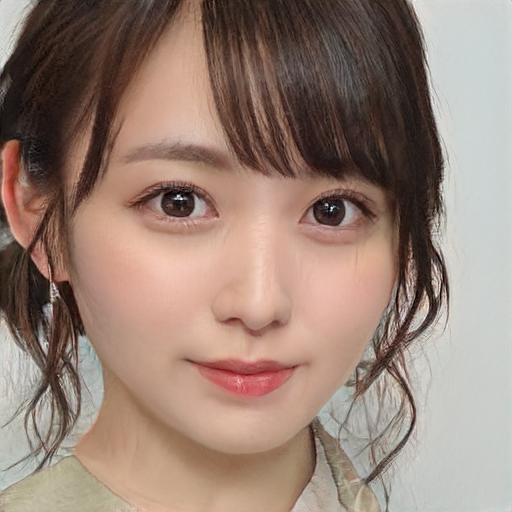

In [30]:
imshow(generate_images_from_seeds(np.random.randint(4294967295, size=1), truncation_psi=0.5)[0])